Using TensorFlow backend.


17465344/17464789 [==============================] - 1s 0us/step
25000
3000
22000
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 22000 samples, validate on 3000 samples
Epoch 1/200
22000/22000 [==============================] - 4s 160us/step - loss: 0.6916 - acc: 0.6342 - val_loss: 0.6834 - val_acc: 0.5887
Epoch 2/200
22000/22000 [==============================] - 2s 101us/step - loss: 0.6763 - acc: 0.7774 - val_loss: 0.6639 - val_acc: 0.7010
Epoch 3/200
22000/22000 [==============================] - 2s 101us/step - loss: 0.6631 - acc: 0.8097 - val_loss: 0.6503 - val_acc: 0.7883
Epoch 4/200
22000/22000 [==============================] - 2s 102us/step - loss: 0.6508 - acc: 0.8614 - val_loss: 0.6322 - val_acc: 0.7617
Epoch 5/200
22000/22000 [==============================] - 2s 105us/step - los

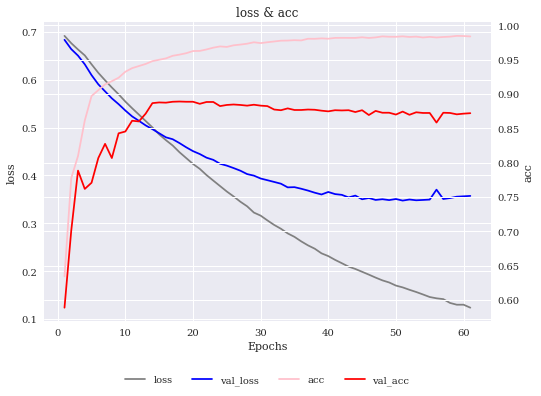

In [1]:
# %%
from keras.datasets import imdb
from keras import models
from keras import regularizers
# from keras import layers
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)
def vectorize_sequence(sequence, dimension= 15000):
    results = np.zeros((len(sequence), dimension))      # (len(sequence), dimension) の零行列
    for i, sequence in enumerate(sequence):     # results[i]のインデックスを1に設定
        results[i, sequence] = 1.
    return results

'''
データの設定
'''
# data:レビューのリスト(単語のシーケンスをエンコード済み)
# labels: 0で「否定的」、1で「肯定的」
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=15000)      # 出現率の高い上位10000語を選択

x_train = vectorize_sequence(train_data)        # 訓練データのベクトル化
x_test = vectorize_sequence(test_data)          # テストデータのベクトル化
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

val_size = 3000

x_val = x_train[:val_size]
partial_x_train = x_train[val_size:]
y_val = y_train[:val_size]
partial_y_train = y_train[val_size:]

print(len(x_train))
print(len(x_val))
print(len(partial_x_train))


'''
モデルの構築
'''
def weight_variable(shape):
    return K.truncated_normal(shape, stddev=0.01)
n_in = len(x_train)
n_out = 1
# n_hiddens = [32,32,32,32,32]
# n_hiddens = [32,32,32,32,32,32,32,32,32]
n_hiddens = [4]
# n_hiddens = [64,64,64,64,64,64,64,64]
p_keep = 0.4
early_stopping = EarlyStopping(monitor= "val_loss", patience= 10, verbose= 1)

model = models.Sequential()
model.add(Dense(4, activation='relu'))
for i, input_shape in enumerate(([n_in]+n_hiddens)[:-1]):
    model.add(Dense(n_hiddens[i], kernel_initializer=weight_variable, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=0.01,l2=0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(p_keep))
model.add(Dense(n_out, kernel_initializer= weight_variable, activation= "sigmoid"))

model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])

'''
モデル学習
'''
history = model.fit(partial_x_train,partial_y_train,epochs=200,batch_size=3000,validation_data=(x_val, y_val), callbacks= [early_stopping], shuffle = True)

'''
予測精度の評価
'''
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

epochs = range(1, len(loss_values) + 1)
plt.rc('font', family='serif')
fig = plt.figure()
ax_loss = fig.add_subplot(111)
g1 = ax_loss.plot(epochs, loss_values, label='loss', color='gray')
g2 = ax_loss.plot(epochs, val_loss_values, label= "val_loss", color="blue")
ax_acc = ax_loss.twinx()
g3 = ax_acc.plot(epochs, acc_values, label='acc', color='pink')
g4 = ax_acc.plot(epochs, val_acc_values, label='val_acc', color='red')
plt.title("loss & acc")

h1, l1 = ax_loss.get_legend_handles_labels()
h2, l2 = ax_acc.get_legend_handles_labels()
ax_loss.legend(h1+h2, l1+l2, loc='upper center',bbox_to_anchor=(0.5,-0.15),ncol=4)

ax_loss.set_xlabel("Epochs")
ax_loss.set_ylabel("loss")
ax_loss.grid(True)
ax_acc.set_ylabel("acc")
plt.show()
